# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import json

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Preprocessing

## Helper Function

In [2]:
def category_plot(df, col, title, fsize=(15,5)):
    plt.figure(figsize=fsize)
    df[col].value_counts(sort=True).plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

def hist_plot(df, col, title, figs=(15,5), nbin=10):
    plt.figure(figsize=figs)
    df[col].hist(bins=nbin)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title(title)
    plt.show()
    
def into_bins(df, col, bins, labels, nan_label='unknown' ):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    
    df[col] = df[col].cat.add_categories(nan_label)
    df[col].fillna(nan_label, inplace =True) 

    df[col] = df[col].astype('str')
    

def pri_missing_perc(df,col):
    print(" {} ({}%) missing values in {} ".format(df[col].isnull().sum(),round(df[col].isnull().sum()/df.shape[0],4), col))


# keep features to be dropped at the end
to_be_dropped=[]

## portfolio

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


 0 (0.0%) missing values in offer_type 


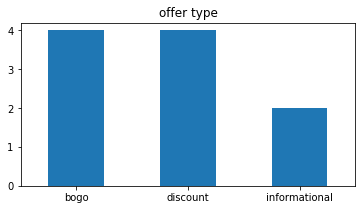

In [4]:
pri_missing_perc(portfolio, 'offer_type')
category_plot(portfolio, 'offer_type', 'offer type', (6,3))

 0 (0.0%) missing values in difficulty 


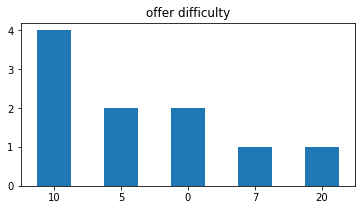

In [5]:
# overall difficulties
pri_missing_perc(portfolio, 'difficulty')
category_plot(portfolio, 'difficulty', 'offer difficulty', (6,3))

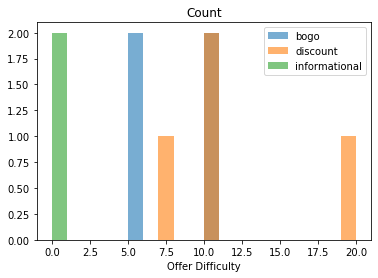

In [6]:
# difficulties for each type of offer

# df['difficulty'].hist(by=df['offer_type'])

grouped = portfolio.groupby('offer_type')
plt.figure()
for group in grouped:
    plt.hist(group[1]['difficulty'],histtype='bar', bins=range(0,21,1), rwidth=1, label=group[0],  alpha=0.6, stacked=True)
plt.legend()
plt.title('Offer Difficulty for Different Offer Types')
plt.xlabel('Offer Difficulty')
plt.title('Count')
plt.show()


 0 (0.0%) missing values in duration 


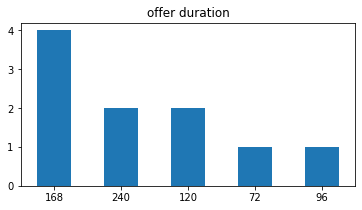

In [7]:
pri_missing_perc(portfolio, 'duration')

# transfer duration of days into hours such that it can be compared to transaction time
portfolio['duration']=portfolio['duration']*24

category_plot(portfolio, 'duration', 'offer duration', (6,3))

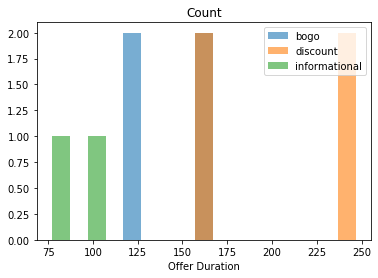

In [8]:
grouped = portfolio.groupby('offer_type')

plt.figure()
for group in grouped:
    plt.hist(group[1]['duration'],histtype='bar', bins=range(portfolio['duration'].min(),portfolio['duration'].max()+20,20), rwidth=0.5, label=group[0],  alpha=0.6, stacked=True)
plt.legend()
plt.title('Offer Duration for Different Offer Types')
plt.xlabel('Offer Duration')
plt.title('Count')
plt.show()

In [9]:
pri_missing_perc(portfolio, 'channels')
channel_types=set([x for i in list(portfolio['channels']) for x in i ])
print('types of offer channels:', channel_types)

 0 (0.0%) missing values in channels 
types of offer channels: {'mobile', 'email', 'social', 'web'}


In [10]:
for x in channel_types:
    portfolio[x]=0
    portfolio.loc[pd.DataFrame(portfolio['channels'].tolist()).isin([x]).any(1),x]=1
portfolio.drop('channels', axis=1, inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,mobile,email,social,web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [11]:
portfolio.groupby('offer_type')[['email', 'social', 'web', 'mobile']].sum()

,email,social,web,mobile
offer_type,,,,
bogo,4,3,3,4
discount,4,2,4,3
informational,2,1,1,2


each offer type comes with four ways of promotion. Since we are not interested in finding out the most effective promting methods in this study, we will only count the total number of methods each offer was sent and they will be stored in "channels" in stead. 

In [12]:
portfolio.loc[:,'channels']=portfolio['email']+portfolio['social']+portfolio['web']+portfolio['mobile']


from observation, it can be seen that for BOGO offer, reward==diffuculty. For informational offer, reward==difficulty==0. For discount offer, rewards is nearly proportional to difficulty. It makes sense to engineer a new feature based on them as the ratio between reward_diff_ratio. This new feature could be taken as the reward you get per difficulty level. 

In [13]:
# portfolio.loc[:,'reward_diff_ratio']=0
# portfolio.loc[portfolio['difficulty']!=0,'reward_diff_ratio']=portfolio[portfolio['difficulty']!=0]['reward']/portfolio[portfolio['difficulty']!=0]['difficulty']
# portfolio



## profile

In [14]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
# check duplicates
profile.duplicated().any()

False

 2175 (0.1279%) missing values in gender 


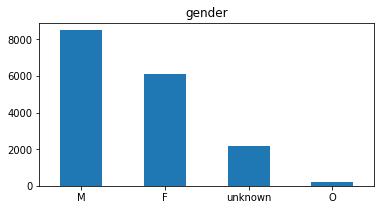

In [16]:
pri_missing_perc(profile, 'gender')
profile['gender'].fillna('unknown', inplace =True) 

category_plot(profile, 'gender', 'gender', (6,3))

 2175 (0.1279%) missing values in income 


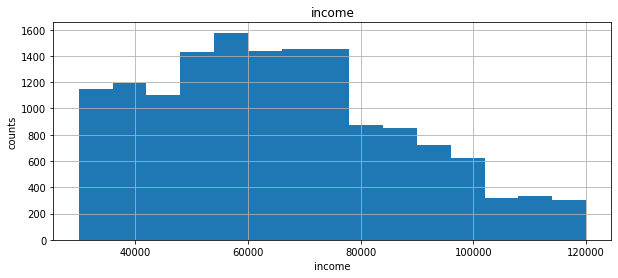

In [17]:
pri_missing_perc(profile, 'income')
hist_plot(profile, 'income', 'income', figs=(10,4), nbin=15)

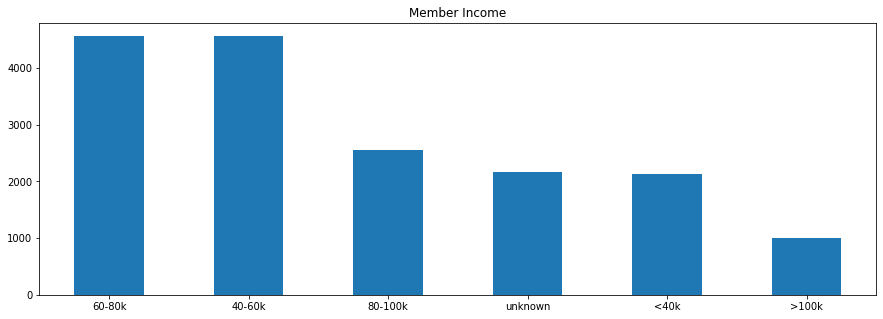

In [18]:
# fill NULL

# # get median and mean
# print("Mean days as host:", round(profile['income'].mean(),2))
# print("Median days as host:", round(profile['income'].median(),2))

# profile['income'].fillna(profile['income'].median(), inplace=True)
# hist_plot(profile, 'income', 'income', figs=(10,4), nbin=10)

into_bins(profile,'income',bins=[0, 40000, 60000, 80000, 100000, 150000],
          labels=['<40k', '40-60k' ,'60-80k', '80-100k','>100k'])
category_plot(profile,'income', 'Member Income')

 0 (0.0%) missing values in age 


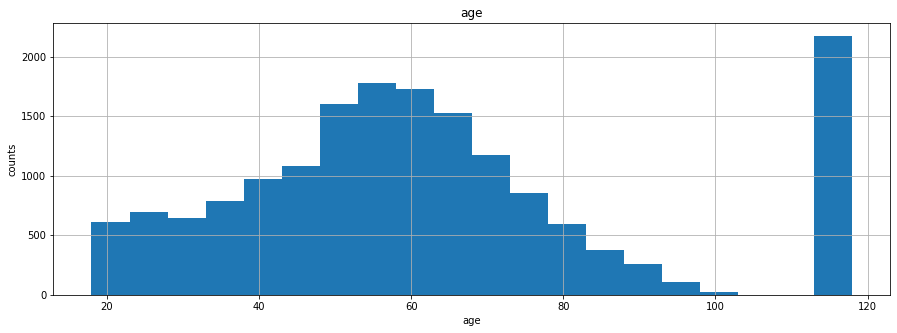

Max age: 118
Percentage of Age 118: 12.7941%


In [19]:
pri_missing_perc(profile, 'age')
hist_plot(profile, 'age', 'age', figs=(15,5), nbin=20)

# get the value of outier
print("Max age:", profile['age'].max())
print('Percentage of Age 118: {}%'.format(round(profile[profile['age']==profile['age'].max()].shape[0]/profile.shape[0]*100, 4)))

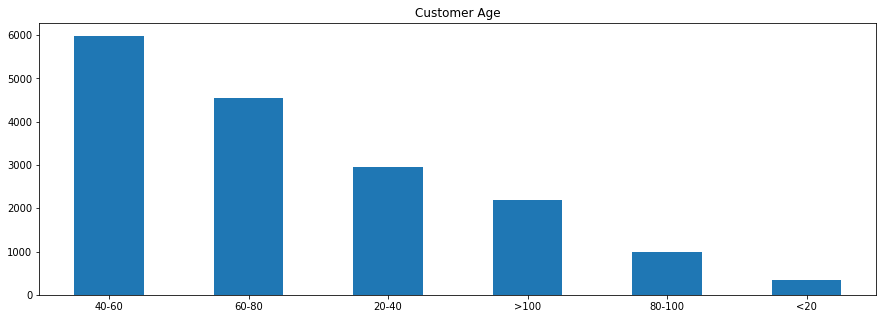

In [20]:
into_bins(profile,'age',bins=[0, 20, 40, 60, 80, 100, 120],
          labels=['<20', '20-40', '40-60' ,'60-80', '80-100','>100'])
category_plot(profile,'age', 'Customer Age')

 0 (0.0%) missing values in became_member_on 


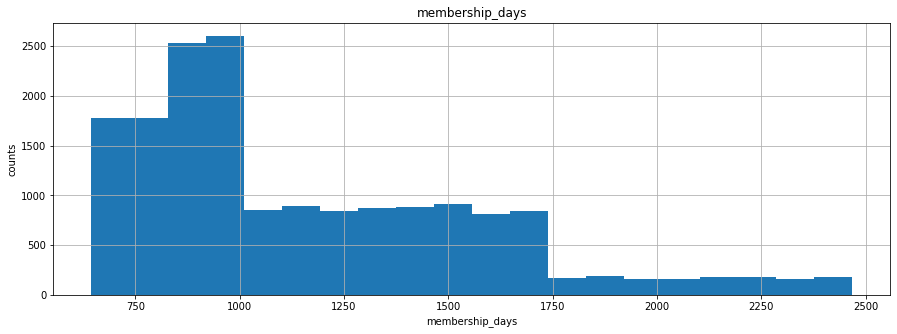

In [21]:
pri_missing_perc(profile, 'became_member_on')

profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype('str'))
profile['membership_days']=(pd.to_datetime('20200501')-profile['became_member_on']).astype('timedelta64[D]')
profile.drop('became_member_on', axis=1, inplace=True)

hist_plot(profile, 'membership_days', 'membership_days', figs=(15,5), nbin=20)

In [22]:
profile.duplicated().any()

False

In [23]:
# after preprocessing
profile.head(10)

,gender,age,id,income,membership_days
0,unknown,>100,68be06ca386d4c31939f3a4f0e3dd783,unknown,1174.0
1,F,40-60,0610b486422d4921ae7d2bf64640c50b,>100k,1021.0
2,unknown,>100,38fe809add3b4fcf9315a9694bb96ff5,unknown,659.0
3,F,60-80,78afa995795e4d85b5d9ceeca43f5fef,80-100k,1088.0
4,unknown,>100,a03223e636434f42ac4c3df47e8bac43,unknown,1001.0
5,M,60-80,e2127556f4f64592b11af22de27a7932,60-80k,736.0
6,unknown,>100,8ec6ce2a7e7949b1bf142def7d0e0586,unknown,949.0
7,unknown,>100,68617ca6246f4fbc85e91a2a49552598,unknown,942.0
8,M,60-80,389bc3fa690240e798340f5a15918d5c,40-60k,812.0
9,unknown,>100,8974fc5686fe429db53ddde067b88302,unknown,1256.0


## transcript

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


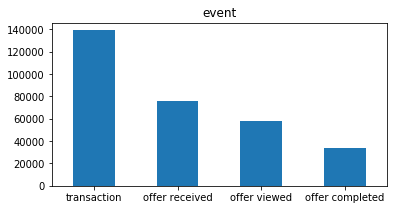

In [25]:
category_plot(transcript, 'event', 'event', (6,3))

In [26]:
key=set([i for item in list(transcript['value']) for i in item.keys()])
key

{'amount', 'offer id', 'offer_id', 'reward'}

In [27]:
# split the value column into three columns: amount, offer id and 'reward'

transcript=pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)
transcript.loc[transcript['offer_id'].isna()==False, 'offer id']=transcript[transcript['offer_id'].isna()==False]['offer_id']
transcript.drop(['offer_id'], axis=1, inplace=True)


In [28]:
# reward will not be considered as transaction amount, it will be deleted later
transcript.rename(columns={'reward':'store_credit'}, inplace=True)

transcript[['offer id']]=transcript[['offer id']].fillna('unknown')
transcript[['amount']]=transcript[['amount']].fillna(0)
transcript[['store_credit']]=transcript[['store_credit']].fillna(0)



In [29]:
print('Number of records', transcript.shape[0])
transcript.duplicated().any()

Number of records 306534


True

In [30]:
transcript.drop_duplicates(inplace=True)
print('Number of records after dropping duplicates', transcript.shape[0])

Number of records after dropping duplicates 306137


### check total transaction amount

In [31]:
transcript.groupby(['offer id'])['amount'].sum()

offer id
0b1e1539f2cc45b7b9fa7c272da2e1d7          0.00
2298d6c36e964ae4a3e7e9706d1fb8c2          0.00
2906b810c7d4411798c6938adc9daaa5          0.00
3f207df678b143eea3cee63160fa8bed          0.00
4d5c57ea9a6940dd891ad53e9dbe8da0          0.00
5a8bc65990b245e5a138643cd4eb9837          0.00
9b98b8c7a33c4b65b9aebfe6a799e6d9          0.00
ae264e3637204a6fb9bb56bc8210ddfd          0.00
f19421c1d4aa40978ebb69ca19b0e20d          0.00
fafdcd668e3743c1bb461111dcafc2a4          0.00
unknown                             1775451.97
Name: amount, dtype: float64

# Dataset Preparation and Analysis

<img src="flowchart.png" alt="Drawing" style="width: 450px;"/>

## Find Effective Offers --> Offer-Driven Purchases

**Category**
* BOGO/Discount offer: "offer completed" event
* informational: "transaction"before offer expires

#### 1. For those whose "offer viewed" happen before "transaction", fill the transaction with "offer id" from "offer viewed" as they may be influenced by offer. Will determine if they are actually influenced by the offer later. 

Steps:
* sorting the transcript dataset by time and then event and group them by person. This will ensure that each event for each person occurs in the right sequence. 
* Then we can check if a "transaction" follows a "offer viewed" event. If so, then we assume that the transaction was potentially influenced by this offer, so we assign the "offer id" from "offer view" event to "transaction" event.  

In [32]:
transcript['event'] = pd.Categorical(transcript['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])

transcript['pre_event']=transcript.sort_values(['time','event']).groupby(['person'])['event'].shift(1)
transcript['pre_offer']=transcript.sort_values(['time','event']).groupby(['person'])['offer id'].shift(1)
transcript.loc[((transcript['event']=='transaction') & (transcript['pre_event']=='offer viewed')), 'offer id']=transcript[((transcript['event']=='transaction') & (transcript['pre_event']=='offer viewed'))]['pre_offer']

transcript.head()


,person,event,time,offer id,amount,store_credit,pre_event,pre_offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,NaN,NaN


#### 2.  Combining all three datasets
steps:
1. merge "profile" with "transcript" based on customer id
2. left merge the combined dataset with "portfolio" based on "offer id".

In [33]:
# merge profile and transcripts based on customer id
df=profile.merge(transcript, left_on='id', right_on='person').drop('id', axis=1)

# merge with offer portfolio based on offer id
df=df.merge(portfolio, left_on='offer id', right_on='id', how='left').drop('id', axis=1)

df.head()

,gender,age,income,membership_days,person,event,time,offer id,amount,store_credit,...,pre_offer,reward,difficulty,duration,offer_type,mobile,email,social,web,channels
0,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,...,NaN,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,3.0
1,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,...,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,3.0
2,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,...,2906b810c7d4411798c6938adc9daaa5,5.0,20.0,240.0,discount,0.0,1.0,0.0,1.0,2.0
3,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,0.0,1.0,0.0,1.0,2.0
4,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,transaction,360,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.35,0.0,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,0.0,1.0,0.0,1.0,2.0


#### 3. Check if offer is still valid at transaction

* get the difference between "transaction" and "offer received" as a new column named "time_since_receive". 
* since all BOGO/discount offers are marked with "offer completed", so it's not necessary to check if transaction activity with this type of offers is within the valid period of the offer. Only informational type of offer is checked here.

In [34]:
# get difference in time

df['time_since_receive']=df[((df['event']=='offer received') | (df['event']=='transaction'))].groupby(['person','offer id'])['time'].diff()



**CAUTION**: df[df['time_since_receive']<df['duration']] may false positives rows for the following cases: 
* offer received - offer received
* transaction - transaction
* offer received - transaction

so "time_since_receive" < "duration" need to used along with other conditions, i.e.:
1. "time_since_receive" < "duration"
2. event == 'transaction'
3. "transaction" has a valid "offer id" (since this indicates this transaction is followed by "offer view" )

#### 4. considred to be an effective offer if the following criterias are met:
1. BOGO/Discount offer --> event is "offer completed"
2. Informational Offer 
    1. "time_since_receive" < "duration"  (time_since_receive is nan for other types of offers)
    2. event is "transaction" 
    3. "transaction" event has an "offer id", indicating it follows an "offer viewed" event

In [35]:
# consider offer to be effective if time_since_receive<duration

# initialize all to 0
df['offer_driven']=0

# offers with "offer completed" happening after "offer viewed" 
df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])
df['pre_event']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_offer']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[((df['event']=='offer completed') & (df['pre_event']=='offer viewed')), 'offer_driven']=1


# offer viewed" before "transaction" AND "time_since_receive"<"duration"
df.loc[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['time_since_receive']<=df['duration']),'offer_driven']=1


## Inactive Customers _ Customers Never Made Any Purchases

In [36]:
# find all customers with purchase history
cust_with_purchase=set(df[df['event'].isin(['offer completed', 'transaction'])].groupby('person')['event'].count().index.to_list())
cust_no_purchase=set(df[~df['person'].isin(cust_with_purchase)]['person'].to_list())
print("There are {} customers that never made a purchase".format(len(cust_no_purchase)))

# a new column "active_customer": 0: inactive; 1: active
df['active_customer']=1
df.loc[df['person'].isin(cust_no_purchase), 'active_customer']=0


There are 422 customers that never made a purchase


## Offer-Irrelevant Purchases
1. standalone "transaction", those not following "offer viewed"
    * "offer id" is unknown
2. "transaction" followed "offer viewed", but
    1. BOGO/Discount offers with "transaction" only, not followed by "offer completed".
    2. Informational offers but transaction happens when offer expired.
   

In [37]:
# initialize all to 0
df['offer_irrelevant']=0

# transaction not following "offer viewed" -- standalone transactions
df.loc[((df['event']=='transaction') & (df['offer id']=='unknown')), 'offer_irrelevant']=1

# transaction follows 'offer viewed', but time_since_receive>duration (informational offer)
df.loc[(df['offer id']!='unknown') & (df['event']=='transaction') & ((df['time_since_receive']>df['duration'])),'offer_irrelevant']=1



In [38]:
# transaction follows 'offer viewed', but not followed by "offer completed" (BOGO/Discount offers)

df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])

df['post_event']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_offer']=df.sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(-1)


df.loc[((df['event']=='transaction') & (df['offer id']!='unknown') & (df['time_since_receive'].isnull()) & ((df['post_event']!='offer completed') | (df['post_offer']!=df['offer id']))), 'offer_irrelevant']=1


In [39]:
# offer completed not following offer viewed

# BOGO/Discount offers with "offer completed" happening after "offer viewed" 
df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'transaction', 'offer completed'])
df['pre_event']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_offer']=df[((df['event']=='offer viewed') |(df['event']=='offer completed'))].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[((df['event']=='offer completed') & ((df['pre_event']!='offer viewed') | (df['pre_event'].isnull()))), 'offer_irrelevant']=1


In [40]:
# Check: total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------


#### delete transactions before "offer completed" and copy transaction amount to "offer complete" event

In [41]:
# copy transaction amount to "offer complete" event
df['pre_amount']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['amount'].shift(1)
df['pre_offer']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(1)
df['pre_event']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(1)

df.loc[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id']), 'amount']=df[(df['event']=='offer completed') & (df['pre_event']=='transaction') & (df['pre_offer']==df['offer id'])]['pre_amount'] 


# delete transactions before "offer completed"
df['post_event']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_offer']=df[(df['event']=='transaction') | (df['event']=='offer completed')].sort_values(['time','event']).groupby(['person', 'offer id'])['offer id'].shift(-1)

df=df.drop(df[(df['offer id']!='unknown') & (df['event']=='transaction') & (df['post_event']=='offer completed') & (df['post_offer']==df['offer id'])].index)


#### sanity check

all "transaction" event remaining shall be labeled either as "offer_irrelevant" or "offer_driven"

In [42]:
df[(df['event']=='transaction') & (df['offer_irrelevant']==0) & (df['offer_driven']==0)].shape[0]

0

all "offer completed" event shall be labeled "offer_irrelevant"==0 and "offer_driven"==1

In [43]:
df[(df['event']=='offer completed')]['offer_driven'].unique()

array([1, 0])

In [44]:
df[(df['event']=='offer completed')]['offer_irrelevant'].unique()

array([0, 1])

all other events should be 0 for both offer_irrelevant and 'offer_driven'

In [45]:
df[(df['event']!='offer completed')& (df['event']!='transaction')]['offer_irrelevant'].unique()

array([0])

In [46]:
df[(df['event']!='offer completed')& (df['event']!='transaction')]['offer_driven'].unique()

array([0])

In [47]:
# total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")

# number of purchases with offer 
print("number of purchases with offer", df[((df['event']=='transaction') & (df['offer id']!='unknown')) | (df['event']=='offer completed') ].shape[0] )
print("number of purchases without offer", df[(df['event']=='transaction') & (df['offer id']=='unknown')].shape[0])
print("total number of purchases", df[(df['event']=='transaction') | (df['event']=='offer completed')].shape[0])


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------
number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150496


In [48]:
# all purchases should be marked as either offer_driven or offer_irrelevant.
print("total number of purchases", df[(df['offer_driven']==1) | (df['offer_irrelevant']==1)].shape[0])

total number of purchases 150496


## More Dataset Exploration and Cleaning

### Transaction Cleaning

**Goal**： keep 1 transaction history for each offer/order. 

**Summary** of the three features added before:
* offer_driven: all "offer_complete" event and qualified "transaction" event == 1
* active_customer: 
    * active customer == 1
    * inactive customer == 0 -- without any transaction/complete
* offer_irrelevant: all other "transaction" event not qualified as "offer_driven" == 1 


**Steps**:
* **A** Each customer may received multiple offers. No matter they used it or not, it is a history of offer sent. So all "offer received" event should be kept. We add a new feature **keep** to flag all rows to be kept.
* **B** There may be standalone transactions without any offers. All of them don't have an "offer id". They will need to be kept.
* **C** For "transaction" (Informational offers), we would like to copy those labels from "transaction"events to their corresponding "offer received" events. 
* **D** For "offer completed" (BOGO/Discount offers), we would like to copy those labels from "offer completed"events to their corresponding "offer received" events. 


In [49]:
df['keep']=0

**A**: "offer received" event for inactive customers

In [50]:
# df.loc[(df['event']=='offer received') & (df['active_customer']==0), 'keep']=1
df.loc[(df['event']=='offer received') , 'keep']=1

**B**: standalone purchases

In [51]:
# standalone transactions
df.loc[((df['event'] == 'transaction') & (df['offer id'] == 'unknown')), 'keep']=1

**C** & **D**
* shift(-1) to check if there is a "transaction" or "order completed" event follows an "offer received". 

In [52]:
df['post_event']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(-1)
df['post_id']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(-1)

df['post_driven']=df[((df['event']=='offer received') | (df['event']=='transaction')  |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_driven'].shift(-1)
df['post_irrelevant']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer_irrelevant'].shift(-1)

df['post_amount']=df[((df['event']=='offer received') | (df['event']=='transaction')  |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['amount'].shift(-1)


**C**: active customer, "offer received", has transactions
* "offer received" is followed by a "transaction" or "order completed" event with the same "offer id"

In [53]:

# flag offer related purchases on "offer receive event" and copy the transaction amount to 'offer received event'
# df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), ['offer_irrelevant','offer_driven', 'amount']]=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])][['post_irrelevant', 'post_driven', 'post_amount']]

# offer received --> offer completed (including offer received --> transaction --> offer completed)
# offer received --> transaction

# mark those records as records to "keep"
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'keep']=1


df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'offer_irrelevant']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_irrelevant']
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'offer_driven']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_driven']
df.loc[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id']), 'amount']=df[(df['event']=='offer received') & ((df['post_event']=='offer completed') | (df['post_event']=='transaction')) & (df['offer id'] == df['post_id'])]['post_amount']


#### Other Cases
transactions that not happening with right order, but already marked with "offer_driven" or "offer_irrelevant"

In [54]:
# offer received --> offer completed  --> transaction
df['pre_event']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_id']=df[((df['event']=='offer received') | (df['event']=='transaction') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[(df['event']=="transaction") & (df['pre_event']=="offer completed") & (df['keep']==0) & ((df['offer_driven']==1)|(df['offer_irrelevant']==1)), 'keep']=1


offer completed happens between two offer received events: offer recieved --> offer received --> offer completed --> offer completed

In [55]:
df['pre_event']=df[((df['event']=='offer received') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['event'].shift(1)
df['pre_id']=df[((df['event']=='offer received') |(df['event']=='offer completed'))].sort_values(['time', 'event']).groupby(['person', 'offer id'])['offer id'].shift(1)

df.loc[(df['event']=="offer completed") & (df['pre_event']=="offer completed") & (df['offer id']==df['pre_id']), 'keep']=1


### Dataset Clean

In [56]:
n_pre_record=df.shape[0]
df=df[(df['keep']==1)]
print("{} records before cleaning. {} records after cleaning".format(n_pre_record,df.shape[0]))

284498 records before cleaning. 176043 records after cleaning


### Sanity Checks

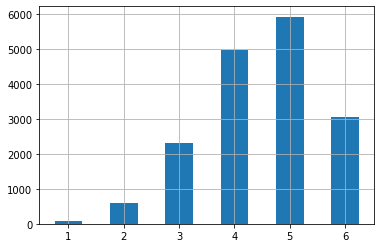

In [57]:
df[df['event']=='offer received'].groupby('person')['event'].count().hist(bins=range(1,8), rwidth=0.5, align='left')


In [58]:
df[(df['event']=='transaction') & ((df['offer_driven']==0) & (df['offer_irrelevant']==0))]

,gender,age,income,membership_days,person,event,time,offer id,amount,store_credit,...,offer_irrelevant,post_event,post_offer,pre_amount,keep,post_id,post_driven,post_irrelevant,post_amount,pre_id


In [59]:
# number of standalone transactions
# df[(df['event']=='transaction')].shape[0]

# equals
df[(df['offer id']=='unknown')].shape[0]

97039

In [60]:
df[((df['event']=='offer received') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1)))].shape[0]


50730

In [61]:
df[(df['offer id']!='unknown')]['offer_driven'].unique()

array([0., 1.])

In [62]:
# total purchase amount
print("total purchase amount with offers", round(df[df['offer id']!='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount without offers", round(df[df['offer id']=='unknown'].groupby('offer id')['amount'].sum().sum()))
print("total purchase amount", round(df.groupby('offer id')['amount'].sum().sum()))

print("--------------------------------------------")

# number of purchases with offer 
print("number of purchases with offer", df[ (df['offer id']!='unknown') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1))].shape[0] )
print("number of purchases without offer", df[(df['offer id']=='unknown')].shape[0])
print("total number of purchases", df[(df['event']=='transaction') | (df['event']=='offer completed')| ((df['event']=='offer received') & ((df['offer_driven']==1) | (df['offer_irrelevant']==1)))].shape[0])


total purchase amount with offers 584549.0
total purchase amount without offers 1190903.0
total purchase amount 1775452.0
--------------------------------------------
number of purchases with offer 53457
number of purchases without offer 97039
total number of purchases 150496


## Remove Irrelevant Features

In [75]:
df_backup=df.copy()

# df=df_backup.copy()

In [77]:
# Drop unnecessary columns
to_be_dropped=[
    'pre_event', 'pre_offer', 'post_event', 'post_offer', 'post_driven','post_irrelevant', 'post_id',  
    'time_since_receive', 'time','store_credit',
    'mobile', 'web', 'email','social','time_since_receive','post_event',
    'post_offer', 'pre_amount', 'keep', 'post_id',
    'post_driven', 'post_irrelevant', 'post_amount', 'pre_id'
]
df=df.drop(to_be_dropped, axis=1)

In [78]:
df.isnull().any()

gender              False
age                 False
income              False
membership_days     False
person              False
event               False
offer id            False
amount              False
reward               True
difficulty           True
duration             True
offer_type           True
channels             True
offer_driven        False
active_customer     False
offer_irrelevant    False
dtype: bool

In [80]:
df[['channels', 'difficulty', 'duration', 'reward']].fillna(0, inplace=True)
df['offer_type'].fillna("NoOffer", inplace=True)

## Data Exploration

In [81]:
df.head()

,gender,age,income,membership_days,person,event,offer id,amount,reward,difficulty,duration,offer_type,channels,offer_driven,active_customer,offer_irrelevant
0,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,10.0,168.0,discount,3.0,0.0,1,0.0
2,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.35,5.0,20.0,240.0,discount,2.0,1.0,1,0.0
5,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.74,2.0,10.0,240.0,discount,4.0,1.0,1,0.0
8,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,1.89,NaN,NaN,NaN,NoOffer,NaN,0.0,1,1.0
9,unknown,>100,unknown,1174.0,68be06ca386d4c31939f3a4f0e3dd783,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,5.04,3.0,7.0,168.0,discount,4.0,1.0,1,0.0


#### Q: How many does offers each person receive?

In [82]:
offer_count=df[df['offer id']!='unknown'].groupby('person')[['person']].count().rename(columns={'person':'offer_cnt'}).reset_index()

# check the customers that never received any offers
a=df['person'].unique()
b=offer_count['person'].unique()
print('Person that never receive any offers:', np.setdiff1d(a,b))

# add the number of offer received to the dataset as a new feature
df=df.merge(offer_count, right_on='person', left_on='person', how='left')
df['offer_cnt'].fillna(0, inplace=True)

Person that never receive any offers: ['12ede229379747bd8d74ccdc20097ca3' '3a4874d8f0ef42b9a1b72294902afea9'
 'ae8111e7e8cd4b60a8d35c42c1110555' 'c6e579c6821c41d1a7a6a9cf936e91bb'
 'da7a7c0dcfcb41a8acc7864a53cf60fb' 'eb540099db834cf59001f83a4561aef3']


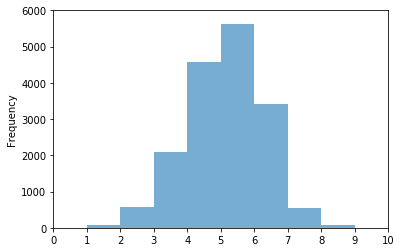

In [83]:
df.groupby('person')['offer_cnt'].mean().plot(kind='hist', alpha=0.6)
plt.xticks(np.arange(df.groupby('person')['offer_cnt'].mean().max()+1))
plt.xlim([0,10]);
plt.ylim([0,6000]);

Text(0.5, 1.0, 'average transaction amount V.S. number of offer received')

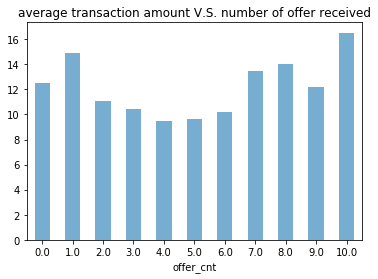

In [84]:
df.groupby("offer_cnt")['amount'].mean().plot(kind='bar', alpha=0.6, rot=0)
plt.title('average transaction amount V.S. number of offer received')

In [85]:
df.columns

Index(['gender', 'age', 'income', 'membership_days', 'person', 'event',
       'offer id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'channels', 'offer_driven', 'active_customer', 'offer_irrelevant',
       'offer_cnt'],
      dtype='object')

### Demographics 

#### Q: Gender

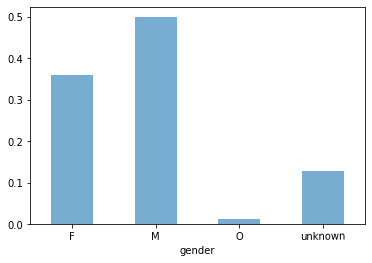

In [86]:
# percentage of male/female gender

(df.groupby('gender')[['person']].nunique()/df.groupby('gender')[['person']].nunique().sum()).plot(kind='bar',legend=False, alpha=0.6, rot=0.6);


#### Q: incomes of Male/Female customers 

In [87]:
A=df[df['gender'].isin(['F', 'M'])].groupby(['gender','income'])[['person']].nunique().reset_index(['income']).pivot_table(index='gender',columns='income', values='person')
A=A[['<40k', '40-60k', '60-80k', '80-100k', '>100k']]


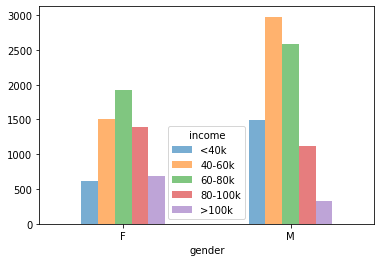

In [88]:
# Count of each income level within female and male

A.plot(kind='bar', alpha=0.6, rot=0)

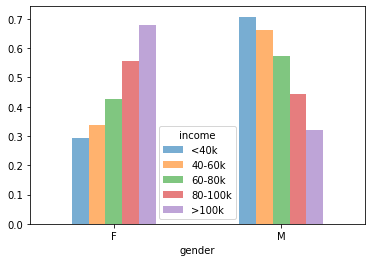

In [89]:
# Percentage of each income level within female and male

A.div(A.sum(axis=0)).plot(kind='bar', alpha=0.6, rot=0)

#### Q:  distribution of days being a member for male/female customer

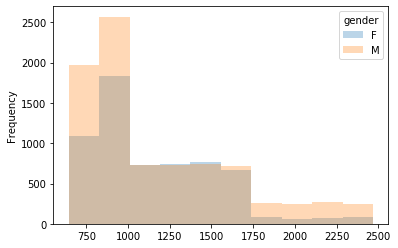

In [90]:
# distribution of days being a member for male/female customer
temp=df[df['gender'].isin(['F', 'M'])].groupby(['gender','person'])[['membership_days']].mean().pivot_table(index='person',columns='gender', values='membership_days')

temp.plot.hist(alpha=0.3);

#### Q: How each gender response to offers
**Answers**:
* there are about the same amount of event turns into transactions in each gender group.
* for all purchases event, the percentages of purchases driven by offer are about the same for all genders.
* Different gender response the same to different types of offers each gender

In [91]:
temp=df.groupby('gender')[['offer_driven', 'offer_irrelevant']].sum()
temp['event_count']=df.groupby('gender')[['offer_driven']].count()
temp['n_purchase']=temp['offer_driven']+temp['offer_irrelevant']
temp['perc_purchase_event']=temp['n_purchase']/temp['event_count']
temp['none_purchase']=temp['event_count']-temp['n_purchase']
temp['perc_nonepurchase_event']=temp['none_purchase']/temp['event_count']
temp

,offer_driven,offer_irrelevant,event_count,n_purchase,perc_purchase_event,none_purchase,perc_nonepurchase_event
gender,,,,,,,
F,15278.0,39767.0,62945,55045.0,0.874494,7900.0,0.125506
M,20856.0,57464.0,91267,78320.0,0.858141,12947.0,0.141859
O,571.0,1356.0,2190,1927.0,0.879909,263.0,0.120091
unknown,4797.0,10407.0,19641,15204.0,0.774095,4437.0,0.225905


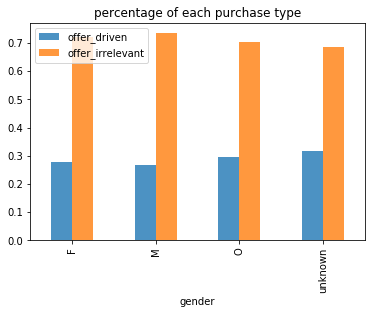

In [92]:
# within all purchases, the percentages of offer-driven purchases and offer-irrelevant purchases are about the same for all genders.
temp[['offer_driven','offer_irrelevant']].div(temp[['offer_driven','offer_irrelevant']].sum(axis=1), axis=0).plot(kind='bar', alpha=0.8);
plt.title('percentage of each purchase type');


For all offer-driven purchases, what's the percentage of differrent types of offers?

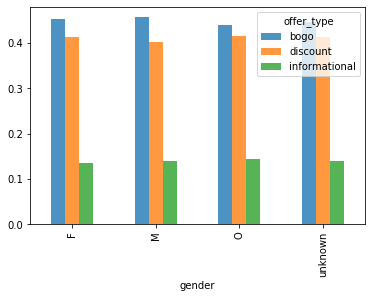

In [93]:
temp=df[df['offer_driven']==1].groupby(['gender', 'offer_type'])[['offer_type']].count().rename(columns={"offer_type":'count'}).reset_index()
temp=temp.pivot_table(index='gender', columns='offer_type', values='count')
temp.div(temp.sum(axis=1), axis=0).plot(kind='bar', alpha=0.8);


#### Q: Income

In [94]:
profile.head(10)

,gender,age,id,income,membership_days
0,unknown,>100,68be06ca386d4c31939f3a4f0e3dd783,unknown,1174.0
1,F,40-60,0610b486422d4921ae7d2bf64640c50b,>100k,1021.0
2,unknown,>100,38fe809add3b4fcf9315a9694bb96ff5,unknown,659.0
3,F,60-80,78afa995795e4d85b5d9ceeca43f5fef,80-100k,1088.0
4,unknown,>100,a03223e636434f42ac4c3df47e8bac43,unknown,1001.0
5,M,60-80,e2127556f4f64592b11af22de27a7932,60-80k,736.0
6,unknown,>100,8ec6ce2a7e7949b1bf142def7d0e0586,unknown,949.0
7,unknown,>100,68617ca6246f4fbc85e91a2a49552598,unknown,942.0
8,M,60-80,389bc3fa690240e798340f5a15918d5c,40-60k,812.0
9,unknown,>100,8974fc5686fe429db53ddde067b88302,unknown,1256.0


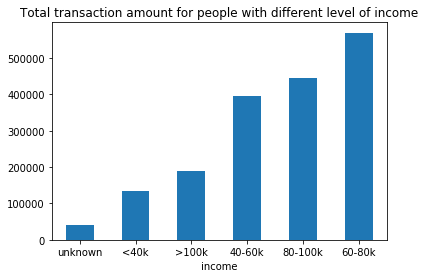

In [95]:
df[(df['offer_driven']==1) | (df['offer_irrelevant']==1)].groupby("income")['amount'].sum().sort_values().plot(kind='bar', rot=0)
plt.title('Total transaction amount for people with different level of income');


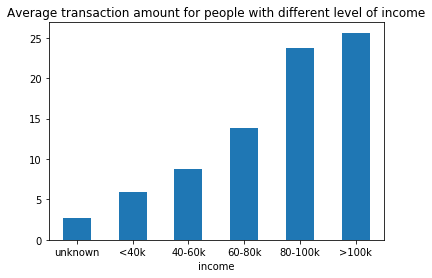

In [96]:
# average amount of purchases driven by offer for different income levels
df[(df['offer_driven']==1) | (df['offer_irrelevant']==1)].groupby("income")['amount'].mean().sort_values().plot(kind='bar', rot=0)
plt.title('Average transaction amount for people with different level of income');


#### Q: which income level is most reponsive to offers? And what type of offers?

##### How many percentages of purchases are driven by offers， for each income range?

In [97]:
temp=df.groupby('income')[['offer_driven', 'offer_irrelevant']].sum()
temp['event_count']=df.groupby('income')[['offer_driven']].count()
temp['n_purchase']=temp['offer_driven']+temp['offer_irrelevant']
temp['perc_purchase_event']=temp['n_purchase']/temp['event_count']
temp['none_purchase']=temp['event_count']-temp['n_purchase']
temp['perc_nonepurchase_event']=temp['none_purchase']/temp['event_count']
temp

,offer_driven,offer_irrelevant,event_count,n_purchase,perc_purchase_event,none_purchase,perc_nonepurchase_event
income,,,,,,,
40-60k,11569.0,33570.0,51856,45139.0,0.870468,6717.0,0.129532
60-80k,11576.0,29495.0,47266,41071.0,0.868933,6195.0,0.131067
80-100k,6202.0,12592.0,22141,18794.0,0.848832,3347.0,0.151168
<40k,5285.0,17612.0,26333,22897.0,0.869517,3436.0,0.130483
>100k,2073.0,5318.0,8806,7391.0,0.839314,1415.0,0.160686
unknown,4797.0,10407.0,19641,15204.0,0.774095,4437.0,0.225905


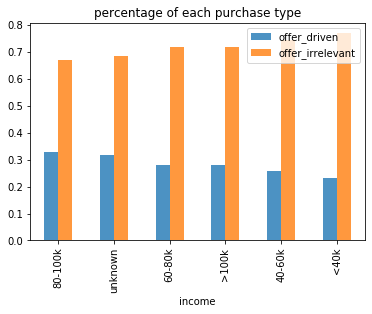

In [98]:
# within all purchases, the percentages of offer-driven purchases and offer-irrelevant purchases are about the same for all genders.
temp[['offer_driven','offer_irrelevant']].div(temp[['offer_driven','offer_irrelevant']].sum(axis=1), axis=0).sort_values(by=['offer_driven'], ascending=False).plot(kind='bar', alpha=0.8);

plt.title('percentage of each purchase type');

##### How many percentages of offer sent leads to an effective purchases?

In [99]:
temp=df[df['offer_type']!='NoOffer'].groupby(['income', 'offer_type'])[['offer_driven']].sum()
temp['count']=df[df['offer_type']!='NoOffer'].groupby(['income', 'offer_type'])[['person']].count()
temp=temp.reset_index()
temp['response_rate']=temp['offer_driven'].div(temp['count'],axis=0)

temp=temp[['income', 'offer_type','response_rate']].pivot_table(index='income', columns='offer_type', values='response_rate')
temp
    

offer_type,bogo,discount,informational
income,,,
40-60k,0.622225,0.531605,0.417527
60-80k,0.599253,0.555889,0.398969
80-100k,0.554579,0.566694,0.335658
<40k,0.629493,0.489816,0.402342
>100k,0.518499,0.466004,0.210349
unknown,0.536225,0.509236,0.347804


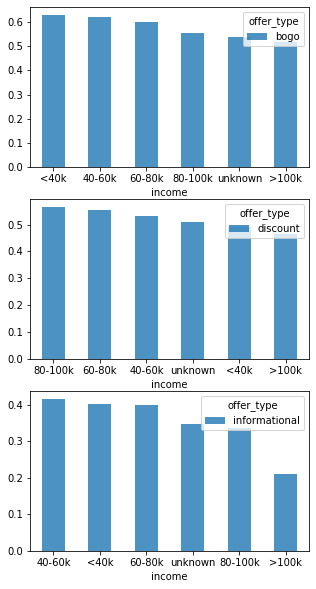

In [100]:
figure, axes = plt.subplots(3,1, figsize=(5,10))
for i,j in enumerate(['bogo', 'discount', 'informational']):
    temp[[j]].sort_values(by=[j], ascending=False).plot(kind='bar', alpha=0.8, rot=0, ax=axes[i]);
plt.show()

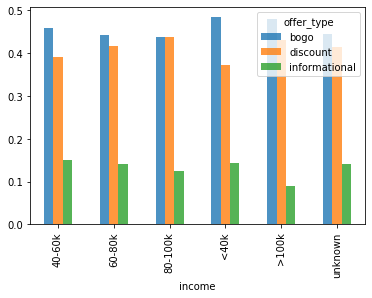

In [101]:
temp=df[df['offer_driven']==1].groupby(['income', 'offer_type'])[['offer_type']].count().rename(columns={"offer_type":'count'}).reset_index()
temp=temp.pivot_table(index='income', columns='offer_type', values='count')
temp.div(temp.sum(axis=1), axis=0).plot(kind='bar', alpha=0.8);


#### Q: membership_days

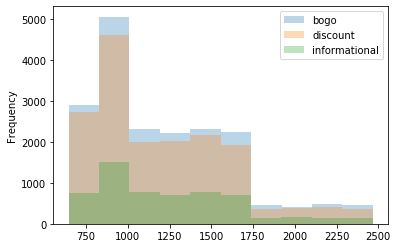

In [102]:
df[(df['offer_driven']==1)].groupby('offer_type')['membership_days'].plot(kind='hist', alpha=0.3, legend=True);

#### Q： Age

In [103]:
temp=df.groupby('age')[['offer_driven', 'offer_irrelevant']].sum()
temp['event_count']=df.groupby('age')[['offer_driven']].count()
temp['n_purchase']=temp['offer_driven']+temp['offer_irrelevant']
temp['perc_purchase_event']=temp['n_purchase']/temp['event_count']
temp['none_purchase']=temp['event_count']-temp['n_purchase']
temp['perc_nonepurchase_event']=temp['none_purchase']/temp['event_count']
temp

,offer_driven,offer_irrelevant,event_count,n_purchase,perc_purchase_event,none_purchase,perc_nonepurchase_event
age,,,,,,,
20-40,7614.0,24289.0,36211,31903.0,0.881031,4308.0,0.118969
40-60,14771.0,37358.0,60645,52129.0,0.859576,8516.0,0.140424
60-80,11054.0,27996.0,45438,39050.0,0.859413,6388.0,0.140587
80-100,2400.0,6133.0,9911,8533.0,0.860963,1378.0,0.139037
<20,853.0,2774.0,4141,3627.0,0.875875,514.0,0.124125
>100,4810.0,10444.0,19697,15254.0,0.774433,4443.0,0.225567


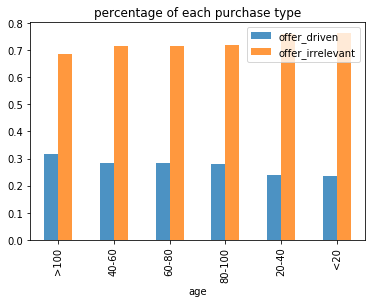

In [104]:
# within all purchases, the percentages of offer-driven purchases and offer-irrelevant purchases are about the same for all genders.
temp[['offer_driven','offer_irrelevant']].div(temp[['offer_driven','offer_irrelevant']].sum(axis=1), axis=0).sort_values(by=['offer_driven'], ascending=False).plot(kind='bar', alpha=0.8);

plt.title('percentage of each purchase type');

In [105]:
temp=df[df['offer_type']!='NoOffer'].groupby(['age', 'offer_type'])[['offer_driven']].sum()
temp['count']=df[df['offer_type']!='NoOffer'].groupby(['age', 'offer_type'])[['person']].count()
temp=temp.reset_index()
temp['response_rate']=temp['offer_driven'].div(temp['count'],axis=0)

temp=temp[['age', 'offer_type','response_rate']].pivot_table(index='age', columns='offer_type', values='response_rate')
temp
    

offer_type,bogo,discount,informational
age,,,
20-40,0.636643,0.523015,0.412886
40-60,0.590539,0.540075,0.382892
60-80,0.579420,0.537721,0.359821
80-100,0.588140,0.537355,0.361884
<20,0.638930,0.491438,0.441558
>100,0.536457,0.509458,0.348095


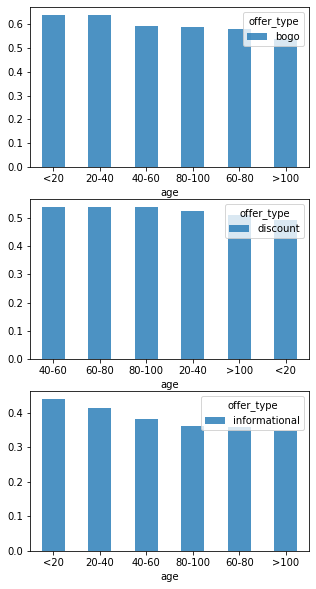

In [106]:
figure, axes = plt.subplots(3,1, figsize=(5,10))
for i,j in enumerate(['bogo', 'discount', 'informational']):
    temp[[j]].sort_values(by=[j], ascending=False).plot(kind='bar', alpha=0.8, rot=0, ax=axes[i]);
plt.show()

### Offer Type

#### Q: number of each offer / offer type sent?

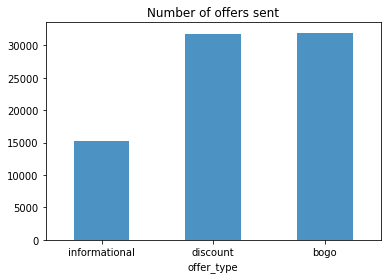

In [107]:
# total transaction amount each offer
df[df['offer id']!='unknown'].groupby("offer_type")['amount'].count().sort_values().plot(kind='bar', alpha=0.8, rot=0);
plt.title('Number of offers sent');

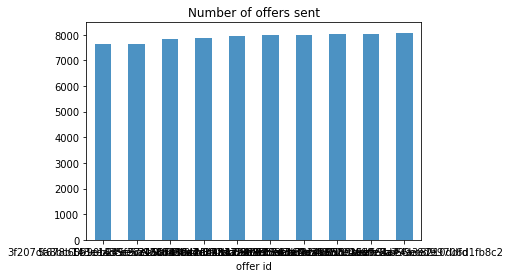

In [108]:
# total transaction amount each offer
df[df['offer id']!='unknown'].groupby("offer id")['amount'].count().sort_values().plot(kind='bar', alpha=0.8, rot=0);
plt.title('Number of offers sent');

#### Q: Percentage of each offer (offer_type) sent that transit to succussful purchases?

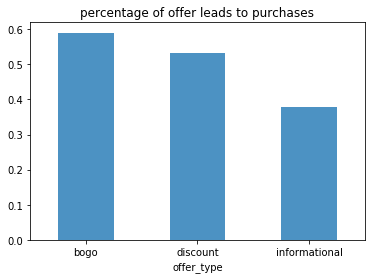

In [109]:
temp=df[df['offer_type']!='NoOffer'].groupby('offer_type')[['amount']].count().rename(columns={'amount':'event_cnt'})
temp['purchase_cnt']=df[(df['offer_driven']==1)].groupby('offer_type')[['event']].count()
temp['response_rate']=temp['purchase_cnt']/temp['event_cnt']
temp['response_rate'].plot(kind='bar', alpha=0.8, rot=0);
plt.title('percentage of offer leads to purchases');

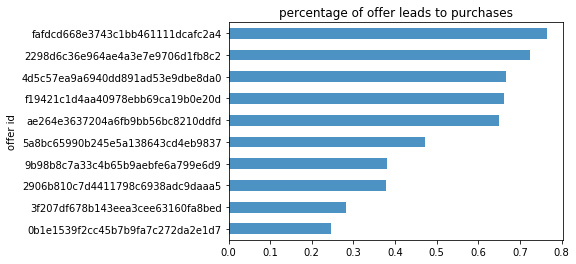

In [110]:
temp=df[df['offer id']!='unknown'].groupby('offer id')[['amount']].count().rename(columns={'amount':'event_cnt'})
temp['purchase_cnt']=df[(df['offer_driven']==1)].groupby('offer id')[['amount']].count()
temp['response_rate']=temp['purchase_cnt']/temp['event_cnt']
temp['response_rate'].sort_values().plot(kind='barh', alpha=0.8);
plt.title('percentage of offer leads to purchases');

#### Q: does percentage of successful transition has anything to do with number of  channels the promotion was sent?

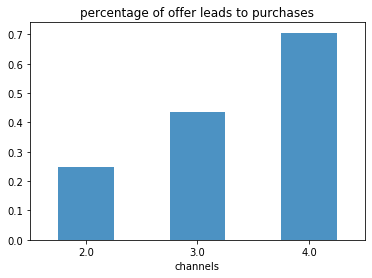

In [111]:
temp=df[df['offer id']!='unknown'].groupby('channels')[['amount']].count().rename(columns={'amount':'event_cnt'})
temp['purchase_cnt']=df[(df['offer_driven']==1)].groupby('channels')[['amount']].count()
temp['response_rate']=temp['purchase_cnt']/temp['event_cnt']
temp['response_rate'].sort_values().plot(kind='bar', alpha=0.8, rot=0);
plt.title('percentage of offer leads to purchases');

#### Q: does percentage of successful transition has anything to do with number of channels the promotion was sent?

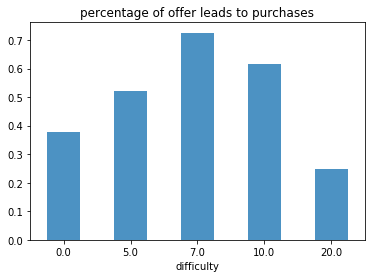

In [112]:
temp=df[df['offer id']!='unknown'].groupby('difficulty')[['amount']].count().rename(columns={'amount':'event_cnt'})
temp['purchase_cnt']=df[(df['offer_driven']==1)].groupby('difficulty')[['amount']].count()
temp['response_rate']=temp['purchase_cnt']/temp['event_cnt']
temp['response_rate'].plot(kind='bar', alpha=0.8, rot=0);
plt.title('percentage of offer leads to purchases');

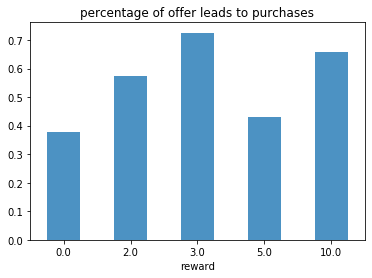

In [113]:
temp=df[df['offer id']!='unknown'].groupby('reward')[['amount']].count().rename(columns={'amount':'event_cnt'})
temp['purchase_cnt']=df[(df['offer_driven']==1)].groupby('reward')[['amount']].count()
temp['response_rate']=temp['purchase_cnt']/temp['event_cnt']
temp['response_rate'].plot(kind='bar', alpha=0.8, rot=0);
plt.title('percentage of offer leads to purchases');

#### Q: Total sales amount associated with each offer

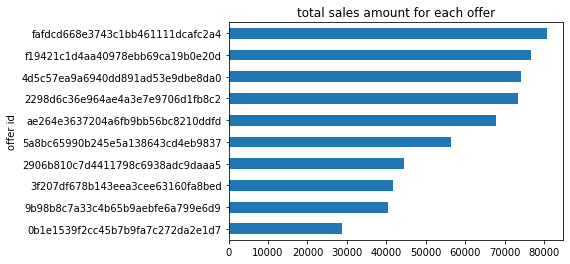

In [114]:
# total transaction amount each offer
df[df['offer id']!='unknown'].groupby("offer id")['amount'].sum().sort_values().plot(kind='barh');
plt.title('total sales amount for each offer');

#### Q: average transaction amount each offer

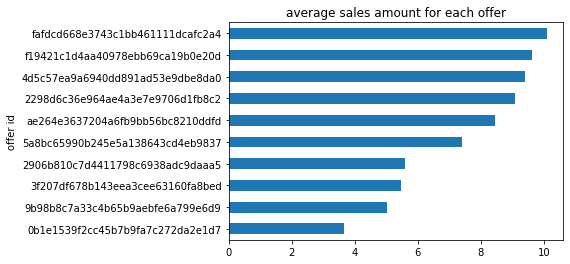

In [115]:
df[df['offer id']!='unknown'].groupby("offer id")['amount'].mean().sort_values().plot(kind='barh')
plt.title('average sales amount for each offer');

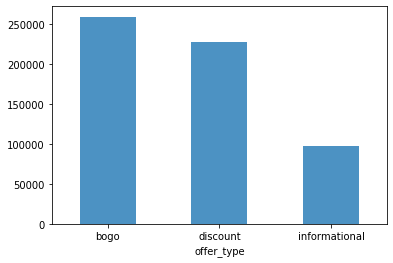

In [121]:
# total transaction amount each offer type

df[df['offer id']!='unknown'].groupby("offer_type")['amount'].sum().plot(kind='bar', alpha=0.8, rot=0)

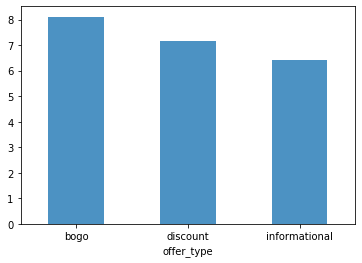

In [120]:
# average purchase amount each offer type
df[df['offer id']!='unknown'].groupby("offer_type")['amount'].mean().plot(kind='bar', alpha=0.8, rot=0)


In [118]:
df[df['offer_irrelevant']==1].groupby("income")['amount'].mean()

income
40-60k      8.553271
60-80k     13.400944
80-100k    22.797031
<40k        5.775324
>100k      24.470564
unknown     2.615969
Name: amount, dtype: float64

# Output to a new Dataset

In [119]:
df.to_json("data/Cleaned_Dataset.json", orient='records') 